# Package

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg  
import seaborn as sns
from scipy.stats import norm
from scipy.stats import shapiro
from statsmodels.stats.stattools import jarque_bera
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import het_arch
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from arch import arch_model
from statsmodels.stats.diagnostic import het_arch, acorr_ljungbox
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.ar_model import AutoReg

# Importation des données

In [36]:
# Lire le fichier brut
with open("lbl-tcp-3.tcp", "r", encoding="latin-1") as f:
    lignes = f.readlines()

# Afficher quelques lignes pour voir la structure
for i, ligne in enumerate(lignes[:20]):  # juste les 20 premières
    print(i, ligne.strip())

0 759103800.008185 1 2 23 2436 1
1 0.010445 2 1 2436 23 2
2 0.023775 1 2 23 2436 2
3 0.026558 2 1 2436 23 1
4 0.029002 3 4 3930 119 42
5 0.032439 4 3 119 3930 15
6 0.049618 1 2 23 2436 1
7 0.052431 5 2 14037 23 2
8 0.056457 2 5 23 14037 2
9 0.057815 6 7 23 1502 414
10 0.072126 8 9 1023 513 0
11 0.098415 3 4 3930 119 55
12 0.104465 4 3 119 3930 15
13 0.122345 10 11 6000 2290 0
14 0.124490 7 6 1502 23 0
15 0.125228 2 1 2436 23 1
16 0.138935 1 2 23 2436 1
17 0.139950 12 13 1208 6000 64
18 0.140930 2 1 2436 23 1
19 0.146912 13 12 6000 1208 32


In [37]:
# Chargement brut : 6 colonnes, séparateur = espaces ----
path = "lbl-tcp-3.tcp"

colnames = ["ts", "src_id", "dst_id", "src_port", "dst_port", "val"]
df = pd.read_csv(
    path,
    sep=r"\s+",            # espaces multiples
    header=None,
    names=colnames,
    engine="python",
    dtype={
        "ts": float,
        "src_id": np.int64,
        "dst_id": np.int64,
        "src_port": np.int64,
        "dst_port": np.int64,
        "val": np.int64
    }
)

In [38]:
df.head()

,ts,src_id,dst_id,src_port,dst_port,val
0,7.591038e+08,1,2,23,2436,1
1,1.044500e-02,2,1,2436,23,2
2,2.377500e-02,1,2,23,2436,2
3,2.655800e-02,2,1,2436,23,1
4,2.900200e-02,3,4,3930,119,42


ts : un temps (soit un timestamp Unix en secondes, soit un temps relatif en secondes).

src_id / dst_id : identifiants d’hôtes (pas des IP, mais des numéros d’hôtes anonymisés).

src_port / dst_port : ports TCP source et destination.

val : c’est la métrique par événement. cette colonne correspond au compte de paquets (si chaque ligne est un agrégat).

In [39]:
df["val"].describe()

count    1.789995e+06
mean     1.363555e+02
std      2.388757e+02
min     -4.000000e+00
25%      0.000000e+00
50%      4.000000e+00
75%      1.250000e+02
max      1.460000e+03
Name: val, dtype: float64

In [40]:
# On doit donc analyser par paquet
# 1) Point de départ
t0 = df['ts'].min()

# 2) Intervalles de 10 s (fenêtres [0,10), [10,20), …, [7190,7200))
df['Interval'] = np.floor((df['ts'] - t0 - 1e-9) / 10).astype(int)

# 3) Garder seulement 720 intervalles (0..719)
df = df[df['Interval'].between(0, 719)]

In [41]:
# On doit donc analyser par paquet
# 1) Point de départ
t0 = df['ts'].min()

# 2) Intervalles de 10 s (fenêtres [0,10), [10,20), …, [7190,7200))
df['Interval'] = np.floor((df['ts'] - t0 - 1e-9) / 10).astype(int)

# 3) Garder seulement 720 intervalles (0..719)
df = df[df['Interval'].between(0, 719)]

In [42]:
# Série de longueur 720 : nombre de lignes par fenêtre de 10 s
ts_series = (
    df.groupby('Interval')
      .size()
      .reindex(range(720), fill_value=0)  # assure les fenêtres vides
)

# Index en temps relatif (0s, 10s, 20s, …)
ts_series.index = pd.to_timedelta(ts_series.index * 10, unit='s')
ts_series.name = 'count'

In [43]:
ts_series

Interval
0 days 00:00:00    1618
0 days 00:00:10    1723
0 days 00:00:20    3226
0 days 00:00:30    1762
0 days 00:00:40    1895
                   ... 
0 days 01:59:10    3163
0 days 01:59:20    2647
0 days 01:59:30    2632
0 days 01:59:40    2169
0 days 01:59:50    2817
Name: count, Length: 720, dtype: int64

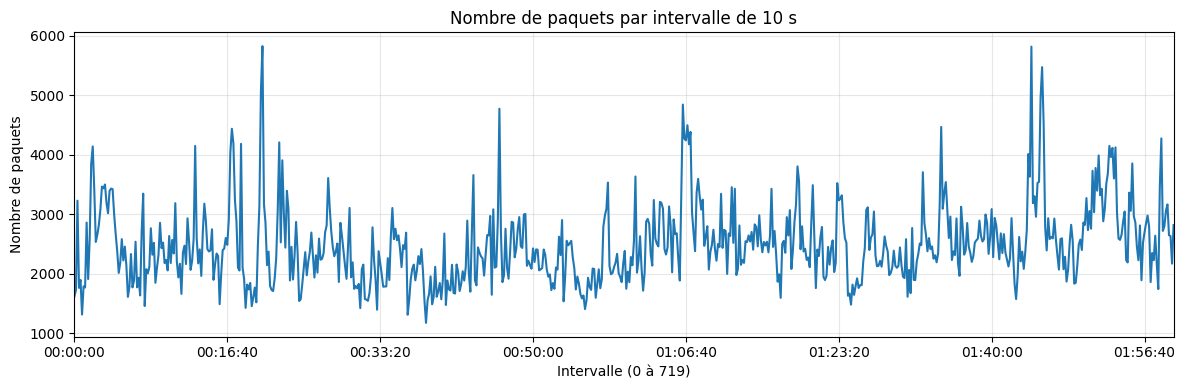

In [44]:
plt.figure(figsize=(12,4))
ts_series.plot()
plt.title("Nombre de paquets par intervalle de 10 s")
plt.xlabel("Intervalle (0 à 719)")
plt.ylabel("Nombre de paquets")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 2. Construction du modèle auto-régressif AR(p)

In [45]:
# Essaie avec AR(1)
mod = AutoReg(ts_series, lags = 3)
res = mod.fit()
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:                  count   No. Observations:                  720
Model:                     AutoReg(3)   Log Likelihood               -5490.242
Method:               Conditional MLE   S.D. of innovations            511.989
Date:                Wed, 03 Sep 2025   AIC                          10990.483
Time:                        15:28:26   BIC                          11013.359
Sample:                             3   HQIC                         10999.316
                                  720                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        843.0268     89.623      9.406      0.000     667.370    1018.684
count.L1       0.5590      0.037     15.031      0.000       0.486       0.632
count.L2       0.0612      0.043      1.438      0.1

d:\Portofolio Data science\Time Series\Travaux pratiques Bases\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


In [46]:
x = min(2, 1.5, 0.5)

print(x)

0.5


In [47]:
# AR avec choix du nombre de retards
# ============================================
# Étape 1 — Préparation des données
# ============================================
y = pd.Series(ts_series, dtype=float).dropna()
n = len(y)
h = int(0.1 * n)                 # 20% pour le test
y_train, y_test = y.iloc[:-h], y.iloc[-h:]
idx_train, idx_test = y_train.index, y_test.index
pmax = min(20, max(5, n // 10))  # borne prudente (modifiable)
K = 5                             # nb de splits pour backtesting

In [48]:
# ============================================
# Étape 2 — Évaluation AIC / BIC pour p = 1..pmax
# ============================================
ic_rows = []
for p in range(1, pmax+1):
    try:
        res = AutoReg(y_train, lags=p, old_names=False).fit()
        ic_rows.append({"p": p, "AIC": res.aic, "BIC": res.bic})
    except Exception:
        ic_rows.append({"p": p, "AIC": np.nan, "BIC": np.nan})
ic_df = pd.DataFrame(ic_rows)

d:\Portofolio Data science\Time Series\Travaux pratiques Bases\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
d:\Portofolio Data science\Time Series\Travaux pratiques Bases\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
d:\Portofolio Data science\Time Series\Travaux pratiques Bases\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
d:\Portofolio Da

In [49]:
ic_df.head()

,p,AIC,BIC
0,1,9922.321125,9935.738164
1,2,9906.991929,9924.875127
2,3,9887.862602,9910.208854
3,4,9867.664754,9894.470946
4,5,9855.202790,9886.465803


In [50]:
# Travail personnel 
s = pd.Series([10,25,30, 50, 70])
print(s)
idx = np.linspace(0, 5, 5, dtype=int)
print(idx)

0    10
1    25
2    30
3    50
4    70
dtype: int64
[0 1 2 3 5]


In [51]:
# Travail personnel 
idx[:3]
print(s[idx[:1]]) # Jusqu'à l'élément 0
print(s[idx[1]:idx[3]]) # A partir de l'élément 1 à 2

0    10
dtype: int64
1    25
2    30
dtype: int64


In [52]:
# ============================================
# Étape 3 — Backtesting dans le TRAIN (fenêtres extensibles) → CV_RMSE
# ============================================
pmax = 20

def ts_cv_rmse_chunks(series: pd.Series, p: int, nchunks: int = 5):
    s = pd.Series(series).dropna()
    n = len(s)
    cuts = np.linspace(0, n, nchunks + 1, dtype=int)
    rmses = []
    for k in range(nchunks - 1):
        train = s.iloc[:cuts[k+1]]
        validation  = s.iloc[cuts[k+1]:cuts[k+2]]
        if len(train) <= p or len(validation) == 0:
            continue
        m = AutoReg(train, lags=p, old_names=False).fit()
        pred = m.forecast(steps=len(validation)); pred.index = validation.index
        rmses.append(np.sqrt(((validation - pred)**2).mean()))
    return float(np.mean(rmses)) if rmses else np.nan

cv_rows = [{"p": p, "CV_RMSE": ts_cv_rmse_chunks(y_train, p, nchunks=K)}
           for p in range(1, pmax+1)]
cv_df = pd.DataFrame(cv_rows)

d:\Portofolio Data science\Time Series\Travaux pratiques Bases\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
d:\Portofolio Data science\Time Series\Travaux pratiques Bases\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
d:\Portofolio Data science\Time Series\Travaux pratiques Bases\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
d:\Portofolio Data science\Time Series\Travaux pratiques Bases\.venv\Lib\site-p

Avec nchunks = 5 : 

Fold 1 : train = 0–20%, test = 20–40%

Fold 2 : train = 0–40%, test = 40–60%

Fold 3 : train = 0–60%, test = 60–80%

Fold 4 : train = 0–80%, test = 80–100%

In [53]:
# ============================================
# Étape 4 — Synthèse des résultats & choix de p
# ============================================
out = ic_df.merge(cv_df, on="p").sort_values("p").reset_index(drop=True)
print("Table des scores (p, AIC, BIC, CV_RMSE):")
print(out)

best_p_aic = out.loc[out["AIC"].idxmin(), "p"]
best_p_bic = out.loc[out["BIC"].idxmin(), "p"]
best_p_cv  = out.loc[out["CV_RMSE"].idxmin(), "p"]

print(f"\nChoix de p :  AIC={best_p_aic} | BIC={best_p_bic} | Backtesting(CV_RMSE)={best_p_cv}")

Table des scores (p, AIC, BIC, CV_RMSE):
     p          AIC          BIC     CV_RMSE
0    1  9922.321125  9935.738164  624.899215
1    2  9906.991929  9924.875127  625.328185
2    3  9887.862602  9910.208854  623.450490
3    4  9867.664754  9894.470946  625.329561
4    5  9855.202790  9886.465803  626.858815
5    6  9840.179376  9875.896083  625.310519
6    7  9827.723395  9867.890660  624.084311
7    8  9815.036964  9859.651646  624.353335
8    9  9799.929758  9848.988707  627.117195
9   10  9786.030970  9839.531029  629.557828
10  11  9772.754275  9830.692281  630.059365
11  12  9752.198850  9814.571630  629.479067
12  13  9733.273514  9800.077889  628.181528
13  14  9720.636178  9791.868962  628.520138
14  15  9706.930854  9782.588851  627.925255
15  16  9693.151782  9773.231791  627.195522
16  17  9680.560306  9765.059117  627.271688
17  18  9667.468332  9756.382728  627.607835
18  19  9652.425982  9745.752738  629.426880
19  20  9639.260057  9736.995940  626.481934

Choix de p : 

In [54]:
df.head()

,ts,src_id,dst_id,src_port,dst_port,val,Interval
3,0.026558,2,1,2436,23,1,0
4,0.029002,3,4,3930,119,42,0
5,0.032439,4,3,119,3930,15,0
6,0.049618,1,2,23,2436,1,0
7,0.052431,5,2,14037,23,2,0


In [55]:
# Travail personnel 
print(df.loc[3]) # 3è ligne, utile pour les index pas entier

ts             0.026558
src_id         2.000000
dst_id         1.000000
src_port    2436.000000
dst_port      23.000000
val            1.000000
Interval       0.000000
Name: 3, dtype: float64


In [56]:
# Travail personnel
df.iloc[3] # Par ordre d'apparition mais pas lié à l'index

ts             0.049618
src_id         1.000000
dst_id         2.000000
src_port      23.000000
dst_port    2436.000000
val            1.000000
Interval       0.000000
Name: 6, dtype: float64

In [57]:
# ============================================
# Étape 5 — Ajustement final (parcimonieux : BIC)
# ============================================
p_final = int(best_p_bic)
final = AutoReg(y_train, lags=p_final).fit()
print(f"\nRésumé du modèle final AR({p_final}):")
print(final.summary())


Résumé du modèle final AR(20):
                            AutoReg Model Results                             
Dep. Variable:                  count   No. Observations:                  648
Model:                    AutoReg(20)   Log Likelihood               -4797.630
Method:               Conditional MLE   S.D. of innovations            503.005
Date:                Wed, 03 Sep 2025   AIC                           9639.260
Time:                        15:28:27   BIC                           9736.996
Sample:                            20   HQIC                          9677.229
                                  648                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        670.5274    156.796      4.276      0.000     363.213     977.842
count.L1       0.5522      0.040     13.835      0.000       0.474       0.630
count.L2       0.038

d:\Portofolio Data science\Time Series\Travaux pratiques Bases\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


In [58]:
# ============================================
# Étape 6 — Test final
# ============================================
pred_test = final.forecast(steps=len(y_test))
pred_test.index = y_test.index

# Erreur sur le jeu de test
rmse_test = np.sqrt(((y_test - pred_test) ** 2).mean())
print(f"RMSE test final: {rmse_test:.4f}")

RMSE test final: 747.4713


d:\Portofolio Data science\Time Series\Travaux pratiques Bases\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
d:\Portofolio Data science\Time Series\Travaux pratiques Bases\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
d:\Portofolio Data science\Time Series\Travaux pratiques Bases\.venv\Lib\site-packages\statsmodels\tsa\deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


La prévision suit juste l'allure au départ mais finalement, elle s'écarte énormément des valeurs réelles. Elle ne suit pas l'allure de la courbe. 

# 10 Analyse des résidus

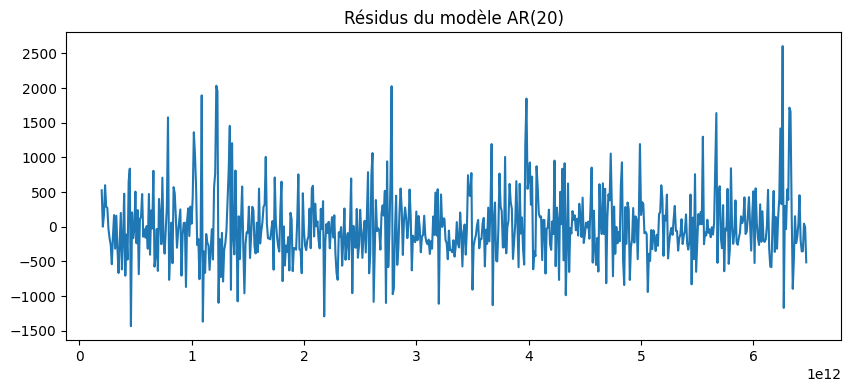

In [61]:
residuals = final.resid

plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.title(f"Résidus du modèle AR({p_final})")
plt.show()

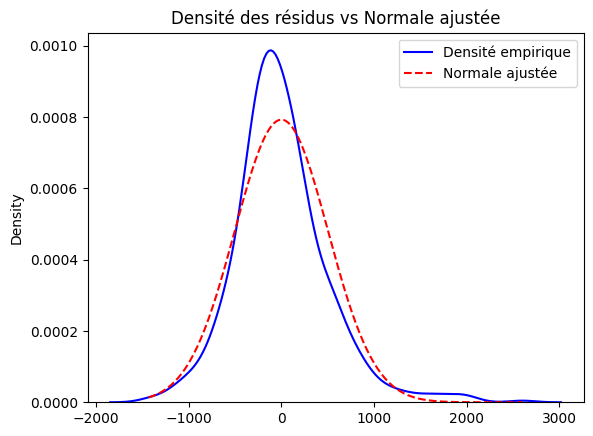

In [62]:

# moyenne et écart-type des résidus
mu, sigma = residuals.mean(), residuals.std()

# tracer la densité empirique
sns.kdeplot(residuals, label="Densité empirique", color="blue")

# tracer la densité normale estimée
x_vals = np.linspace(min(residuals), max(residuals), 200)
plt.plot(x_vals, norm.pdf(x_vals, mu, sigma), 'r--', label="Normale ajustée")

plt.title("Densité des résidus vs Normale ajustée")
plt.legend()
plt.show()


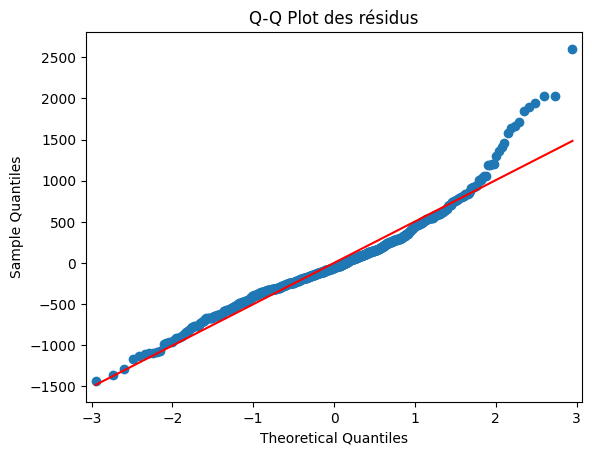

In [63]:
sm.qqplot(residuals, line='s')
plt.title("Q-Q Plot des résidus")
plt.show()

In [64]:
# Test de Shapiro-Wilk
shapiro_stat, shapiro_p = shapiro(residuals)
print("Test de Shapiro-Wilk :")
print(f"Statistique = {shapiro_stat:.4f}, p-value = {shapiro_p:.4f}")

# Test de Jarque-Bera
jb_stat, jb_p, skew, kurt = jarque_bera(residuals)
print("\nTest de Jarque-Bera :")
print(f"Statistique = {jb_stat:.4f}, p-value = {jb_p:.4f}")
print(f"Asymétrie (skewness) = {skew:.4f}, Kurtose = {kurt:.4f}")

Test de Shapiro-Wilk :
Statistique = 0.9499, p-value = 0.0000

Test de Jarque-Bera :
Statistique = 303.6831, p-value = 0.0000
Asymétrie (skewness) = 0.9302, Kurtose = 5.8539


Les résidus ne sont pas distribués normalement. En effet, l'allure de la courbe de leur distribution s'écarte nettement de celle d'une Loi normale. Les tests de normalités confirment qu'on rejette l'hypothèse de normalité.  

La prévision reste valide mais l'inférence statistique ne l'est pas. çà veut dire que les intervvales de confiance autour des prévisions risquent d'être trop optimistes. (sous-estimation de l'incertitude). 

Dans ce cas, il est nécessaire de recourir à des modèles adaptés comme les modèles GARCH. 

Voyons d'abord pourquoi AR n'a pas bien marché.

# Etablir une stratégie d'amélioration du modèle AR

In [65]:
# Test de stationnarité
result = adfuller(y, autolag='AIC')
    
print("=== Test de Dickey-Fuller augmenté (ADF) ===")
print(f"Statistique ADF : {result[0]:.4f}")
print(f"p-value        : {result[1]:.4f}")
print("Valeurs critiques :")
for key, value in result[4].items():
    print(f"   {key}: {value:.4f}")

=== Test de Dickey-Fuller augmenté (ADF) ===
Statistique ADF : -8.2737
p-value        : 0.0000
Valeurs critiques :
   1%: -3.4395
   5%: -2.8656
   10%: -2.5689


On rejette H0 : la série n'est pas stationnaire. La série est donc déjà stationnaire. Ce qui veut dire que la raison de non normalité des résidus est à recherché.

D'après l'allure du graphique des résidus, il me semble qu'ils ne sont pas homoscedastiques. 

Voyons ce point de plus près. 

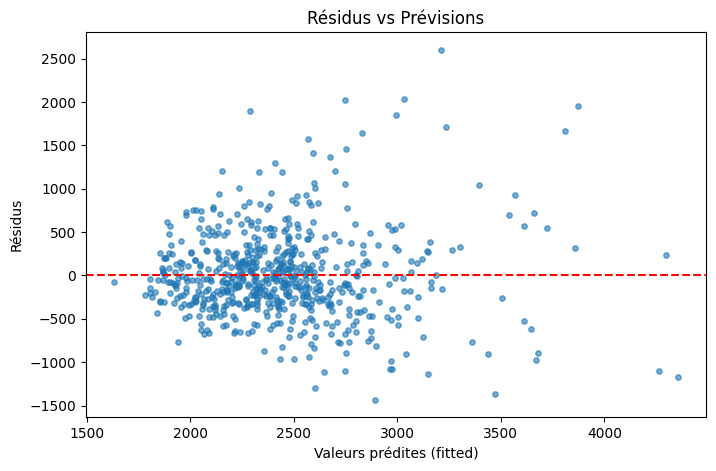

In [66]:
# Vérification de l'homoscedasticité
fitted = final.fittedvalues   # valeurs prédites in-sample
resid = final.resid           # résidus du modèle

plt.figure(figsize=(8,5))
plt.scatter(fitted, resid, s=15, alpha=0.6)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Valeurs prédites (fitted)")
plt.ylabel("Résidus")
plt.title("Résidus vs Prévisions")
plt.show()

Le nuage Résidus vs Prévisions montre une dispersion croissante, signe d’hétéroscédasticité (variance non constante). Le nouveau choix de p avec d'autres critères que BIC ne règle pas le problème. 

Un modèle ARCH/GARCH serait plus adapté.
Mais avant d’en tester un, il faut confirmer statistiquement l’hétéroscédasticité (ex. test d’Engle) et vérifier la spécification des résidus (ACF/PACF des résidus et de leurs carrés). 

In [67]:
# Tester l'homoscedasticité
resid = final.resid.dropna()
arch_stat, arch_pval, _, _ = het_arch(resid, nlags=12)

print("=== Test d'Engle ARCH ===")
print(f"Statistique : {arch_stat:.4f}")
print(f"p-value     : {arch_pval:.4f}")
print("H0 : pas d'effet ARCH (variance constante).")
print("Si p-value < 0.05 → hétéroscédasticité (ARCH) détectée.")

=== Test d'Engle ARCH ===
Statistique : 66.8863
p-value     : 0.0000
H0 : pas d'effet ARCH (variance constante).
Si p-value < 0.05 → hétéroscédasticité (ARCH) détectée.


Cela confirme une hétéroscédasticité conditionnelle : la variance des résidus n’est pas constante.

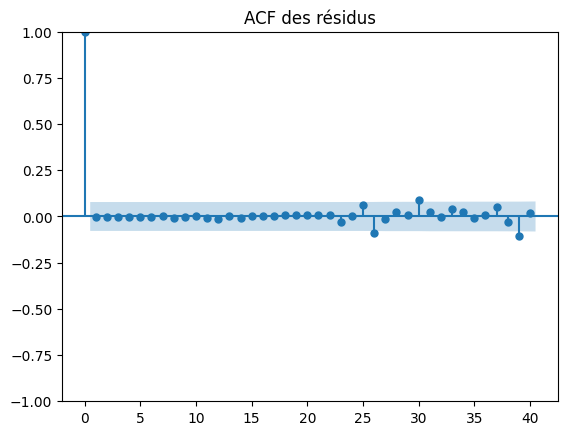

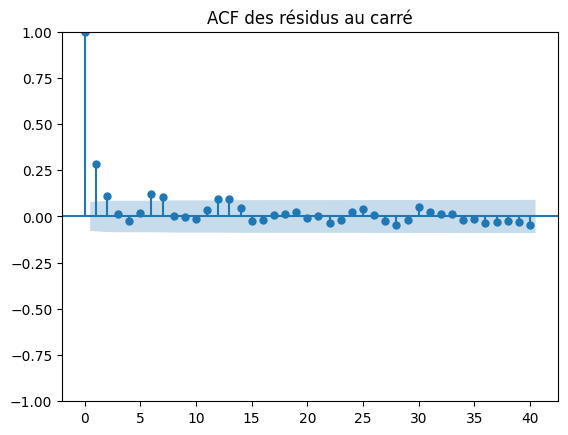

In [68]:
# Présenter l'autocorrélation significative
# ACF des résidus
plot_acf(resid, lags=40)
plt.title("ACF des résidus")
plt.show()

# ACF des résidus au carré
plot_acf(resid**2, lags=40)
plt.title("ACF des résidus au carré")
plt.show()

ACF des résidus au carré nous signalent la présence de plusieurs autocorrélations significatives. La variance des résidus n’est donc pas constante → effet ARCH présent.

# 12. Optimiser le Modèle (G)ARCH pour modéliser la volatilité

Ici, on utilise le Backtesting aussi en fait.

In [69]:
import numpy as np
import pandas as pd
from arch import arch_model

# 0) Entrées supposées déjà prêtes :
# y_train, y_test, p_final, final (AR entraîné sur tout y_train), resid = final.resid.dropna()

def qlike_loss(e2, sig2, eps=1e-8):
    """QLIKE = log(sig2) + e2/sig2 (met l’accent sur les erreurs de variance).
       e2: epsilon^2 observé ; sig2: variance conditionnelle prédite."""
    sig2 = np.maximum(sig2, eps)
    return np.log(sig2) + e2 / sig2

def garch_cv_qlike(resid: pd.Series, specs, nchunks=5, dist="normal"):
    """CV en fenêtres extensibles sur résidus : 1-pas-devant rolling avec refit à chaque pas."""
    s = pd.Series(resid).dropna()
    n = len(s)
    cuts = np.linspace(0, n, nchunks + 1, dtype=int)
    out = []

    for name, (p, q) in specs.items():
        losses = []
        for k in range(nchunks - 1):
            train = s.iloc[:cuts[k+1]]
            val   = s.iloc[cuts[k+1]:cuts[k+2]]
            if len(val) < 5 or len(train) < max(p, q) + 5:
                continue

            preds, e2 = [], []
            for t in range(len(val)):
                # données dispos à l’instant t (tout jusqu’à t-1)
                end_idx = train.index[-1] if t == 0 else val.index[t-1]
                s_fit = s.loc[:end_idx]

                am = arch_model(s_fit, mean="Zero", vol="GARCH", p=p, q=q, dist=dist)
                res = am.fit(disp="off")
                fc  = res.forecast(horizon=1)
                sig2_next = float(fc.variance.iloc[-1, 0])  # σ̂_{t}^2 pour l’observation suivante
                preds.append(sig2_next)
                e2.append(val.iloc[t]**2)                   # ε_t^2 observé

            loss = qlike_loss(np.array(e2), np.array(preds)).mean()
            losses.append(loss)

        out.append({"Model": name, "p": p, "q": q,
                    "QLIKE_CV": np.mean(losses) if losses else np.nan})

    return pd.DataFrame(out).sort_values("QLIKE_CV", na_position="last").reset_index(drop=True)

# 1) Définir les candidats
specs = {
    "ARCH(1)":     (1,0),
    "ARCH(2)":     (2,0),
    "GARCH(1,1)":  (1,1),
    "GARCH(1,2)":  (1,2),
    "GARCH(2,1)":  (2,1),
}

# 2) Lancer la CV (tu peux aussi essayer dist="t")
cv_table = garch_cv_qlike(resid, specs, nchunks=5, dist="normal")
print(cv_table)

# 3) Choisir le meilleur (min QLIKE_CV)
best_row   = cv_table.iloc[0]
best_name  = best_row["Model"]
best_p, best_q = int(best_row["p"]), int(best_row["q"])
print(f"\nMeilleur GARCH (CV QLIKE): {best_name}  -> p={best_p}, q={best_q}")


d:\Portofolio Data science\Time Series\Travaux pratiques Bases\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 3.715e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
d:\Portofolio Data science\Time Series\Travaux pratiques Bases\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 3.711e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  war

        Model  p  q   QLIKE_CV
0     ARCH(2)  2  0  13.222568
1  GARCH(2,1)  2  1  13.234184
2  GARCH(1,1)  1  1  13.234219
3  GARCH(1,2)  1  2  13.237034
4     ARCH(1)  1  0  13.258822

Meilleur GARCH (CV QLIKE): ARCH(2)  -> p=2, q=0


d:\Portofolio Data science\Time Series\Travaux pratiques Bases\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.542e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
d:\Portofolio Data science\Time Series\Travaux pratiques Bases\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.54e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warn

# 13. Train du modèle ARCH5(2) avec les hyperparamètres et en deux étapes

In [70]:
# ARCH(2) sur les résidus du AR
am_final = arch_model(resid, mean="Zero", vol="ARCH", p=2, dist="normal")
arch_final = am_final.fit(disp="off")
print(arch_final.summary())

                        Zero Mean - ARCH Model Results                        
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.002
Vol Model:                       ARCH   Log-Likelihood:               -4759.54
Distribution:                  Normal   AIC:                           9525.08
Method:            Maximum Likelihood   BIC:                           9538.40
                                        No. Observations:                  628
Date:                Wed, Sep 03 2025   Df Residuals:                      628
Time:                        15:29:58   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      1.3916e+05  1.721e+04      8.088  6.061e-16 [1.

d:\Portofolio Data science\Time Series\Travaux pratiques Bases\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.53e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [72]:
import matplotlib.pyplot as plt

# Variance conditionnelle estimée par le GARCH choisi
sigma2_t = fits[best_model].conditional_volatility**2  

# Résidus au carré (issus du AR)
resid_sq = resid**2

# ================================
# Graphique : σ_t² vs ε_t²
# ================================
plt.figure(figsize=(12,6))
plt.plot(resid_sq, color="grey", alpha=0.5, label=r"Résidus AR$^2$ ($\varepsilon_t^2$)")
plt.plot(sigma2_t, color="red", linewidth=2, label=fr"Variance conditionnelle estimée $\sigma_t^2$ ({best_model})")

plt.title(f"Comparaison : Résidus au carré vs Volatilité conditionnelle ({best_model})")
plt.xlabel("Temps")

plt.ylabel("Amplitude")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

NameError: name 'fits' is not defined

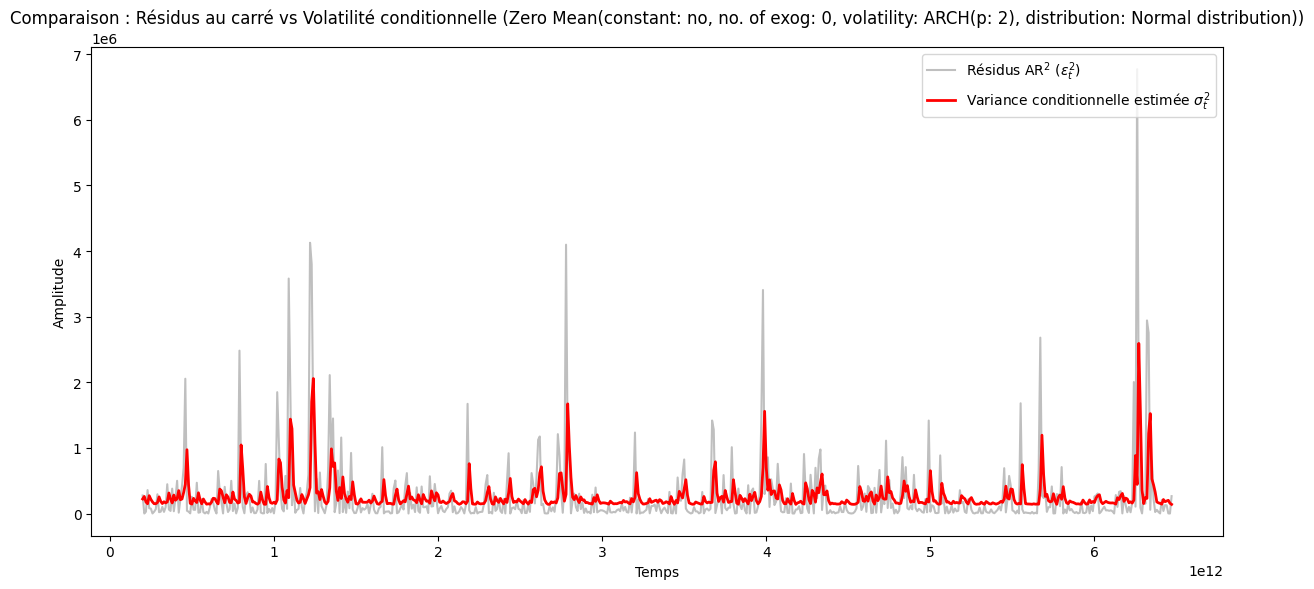

In [77]:
import matplotlib.pyplot as plt

# Variance conditionnelle estimée par ton modèle ARCH/GARCH
sigma2_t = arch_final.conditional_volatility ** 2  

# Résidus au carré (issus du AR)
resid_sq = resid ** 2

# ================================
# Graphique : σ_t² vs ε_t²
# ================================
plt.figure(figsize=(12,6))
plt.plot(resid_sq, color="grey", alpha=0.5, label=r"Résidus AR$^2$ ($\varepsilon_t^2$)")
plt.plot(sigma2_t, color="red", linewidth=2, 
         label=r"Variance conditionnelle estimée $\sigma_t^2$")

plt.title(f"Comparaison : Résidus au carré vs Volatilité conditionnelle ({arch_final.model})")
plt.xlabel("Temps")
plt.ylabel("Amplitude")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

# 14. Graphique de l'estimation de GARCH des résidus

In [ ]:
fc = garch_final.forecast(horizon=len(y_test))

# Prévision de la moyenne conditionnelle (point forecast)
pred_test = fc.mean.iloc[-1]
pred_test.index = y_test.index

# Prévision de la variance conditionnelle (volatilité)
sigma_test = np.sqrt(fc.variance.iloc[-1])
sigma_test.index = y_test.index

Le graphique compare les résidus au carré du modèle AR(20) (courbe grise, très bruitée) et la variance conditionnelle estimée par le GARCH(1,2) (courbe rouge lissée).

On observe que :
- Les pics des résidus au carré correspondent à des périodes de forte volatilité.
- Le GARCH(1,2) ne suit pas chaque pic isolé, mais il capte l’intensité globale de la volatilité :
-- lorsque de grands chocs apparaissent, la variance conditionnelle estimée augmente,
-- lorsqu’il n’y a pas de chocs, la variance diminue.

La courbe rouge agit comme une enveloppe lissée des fluctuations grises, ce qui correspond exactement au rôle d’un modèle GARCH : modéliser la dynamique de la variance conditionnelle sans reproduire le bruit.

# 15. AR + GARCH en graphique

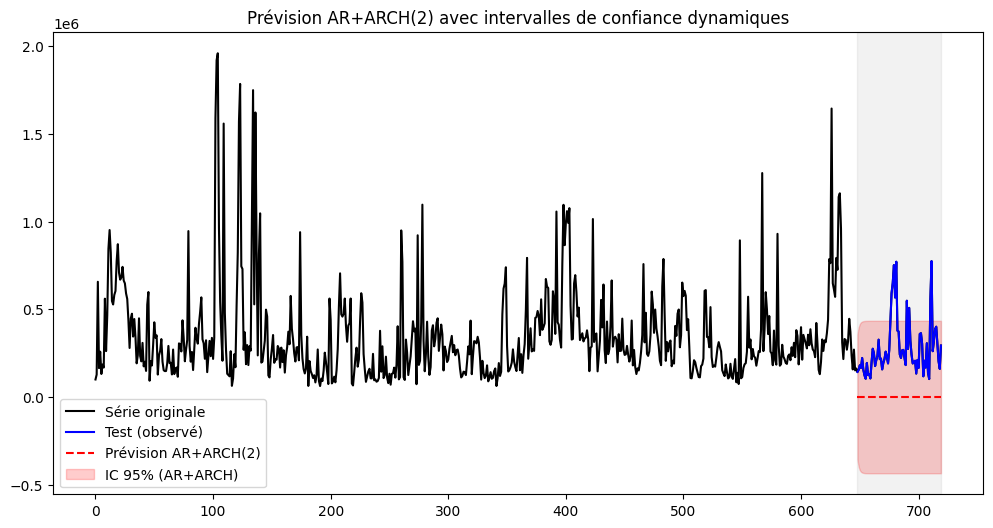

In [ ]:
# ================================
# Prévision avec AR + ARCH intégré
# ================================
h = len(y_test)

# forecast depuis le modèle AR+ARCH final
fc = arch_final.forecast(horizon=h)

# Prévision de la moyenne conditionnelle (point forecast)
pred_mean = fc.mean.iloc[-1]
pred_mean.index = y_test.index

# Prévision de la variance conditionnelle
pred_var = fc.variance.iloc[-1]
pred_sigma = np.sqrt(pred_var)
pred_sigma.index = y_test.index

# IC 95%
upper = pred_mean + 2*pred_sigma
lower = pred_mean - 2*pred_sigma

# ================================
# Visualisation
# ================================
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(y, color="black", label="Série originale")
plt.plot(y_test, color="blue", label="Test (observé)")
plt.plot(pred_mean, color="red", linestyle="--", label="Prévision AR+ARCH(2)")
plt.fill_between(y_test.index, lower, upper, color="red", alpha=0.2,
                 label="IC 95% (AR+ARCH)")
plt.axvspan(y_test.index[0], y_test.index[-1], color="grey", alpha=0.1)
plt.legend()
plt.title("Prévision AR+ARCH(2) avec intervalles de confiance dynamiques")
plt.show()

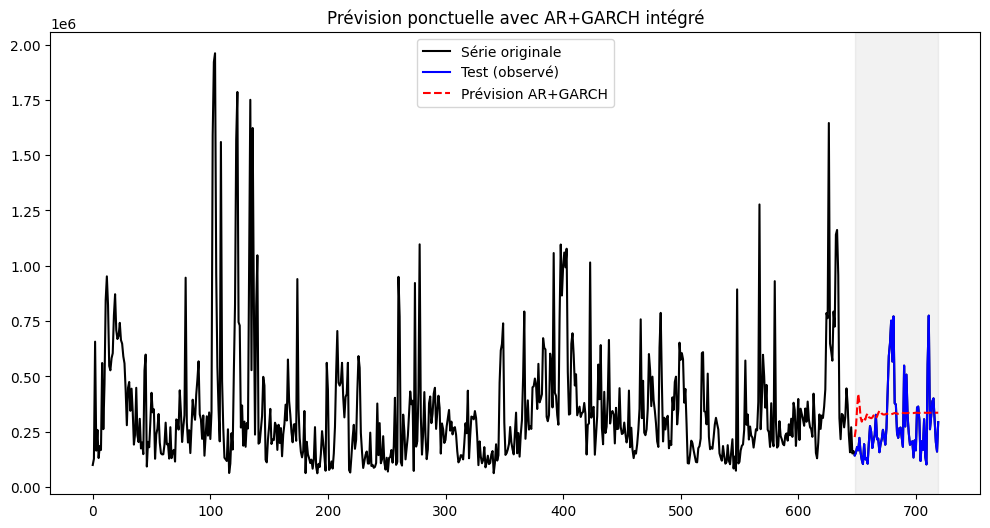

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(y, color="black", label="Série originale")
plt.plot(y_test, color="blue", label="Test (observé)")
plt.plot(pred_mean, color="red", linestyle="--", label="Prévision AR+GARCH")
plt.axvspan(y_test.index[0], y_test.index[-1], color="grey", alpha=0.1)
plt.legend()
plt.title("Prévision ponctuelle avec AR+GARCH intégré")
plt.show()
